In [1]:
import pandas as pd
from pathlib import Path
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
from tqdm import tqdm

%matplotlib inline
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [2]:
download_path = Path.cwd() / ".dataset"

# Read metadata file
labels_file = download_path / "Y_train_ofTdMHi.csv"
df = pd.read_csv(labels_file)

# Construct file path by concatenating fold and file name
df["relative_path"] = str(download_path) + "/X_train/" + df["id"]
df.drop(columns=["id"], inplace=True)
df.rename(columns={"pos_label": "label"}, inplace=True)
# invert relative_path and label columns positions
df = df[["relative_path", "label"]]
print(f"There are ** {len(df)} ** audio files in the dataset.", end="\n\n")
print(f"{df['label'].value_counts()}")
df.head()

There are ** 23168 ** audio files in the dataset.

label
0.0    13718
1.0     9450
Name: count, dtype: int64


,relative_path,label
0,/Users/tristangclvs/Documents/ENSC/3A/S9/Spé ...,0.0
1,/Users/tristangclvs/Documents/ENSC/3A/S9/Spé ...,1.0
2,/Users/tristangclvs/Documents/ENSC/3A/S9/Spé ...,1.0
3,/Users/tristangclvs/Documents/ENSC/3A/S9/Spé ...,1.0
4,/Users/tristangclvs/Documents/ENSC/3A/S9/Spé ...,1.0


Take one file to check mfcc with librosa

Audio data shape: (51200,), Sample rate: 256000


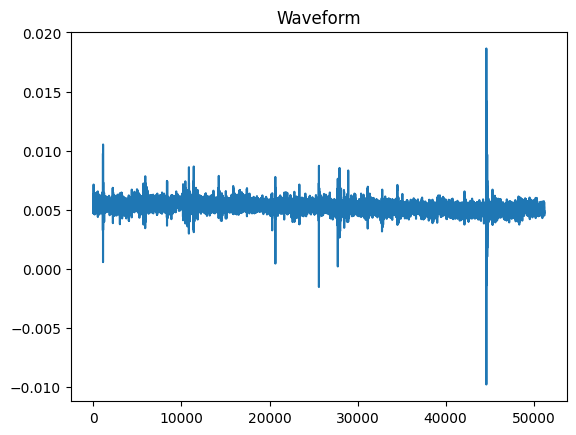

In [3]:
file_path = df.iloc[1, 0]
audio_data, sr = librosa.load(file_path, sr=None)
print(f"Audio data shape: {audio_data.shape}, Sample rate: {sr}")

# Plot the audio signal
fig, ax = plt.subplots(nrows=1, sharex=True)
plt.plot(audio_data)
plt.title('Waveform')
plt.show()

In [4]:
mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=40)
mfccs

/Users/tristangclvs/Documents/ENSC/3A/S9/Spé IA/projet/spe_IA_clics_odontocetes/.venv/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


array([[-5.87434937e+02, -6.10608276e+02, -6.47601562e+02, ...,
        -7.11389832e+02, -6.39985657e+02, -6.06298767e+02],
       [ 1.00062149e+02,  7.29735870e+01, -4.71224880e+00, ...,
         3.30139313e+01,  9.36258774e+01,  1.10256996e+02],
       [-3.51189117e+01, -2.84769020e+01, -3.56545715e+01, ...,
        -4.42377205e+01, -3.34627762e+01, -3.60441856e+01],
       ...,
       [-1.05478287e-01, -7.69059181e-01, -1.04429626e+01, ...,
        -4.63013649e-01,  1.15666771e+00,  1.49537373e+00],
       [ 4.46856499e-01,  2.77732611e+00,  4.64340448e+00, ...,
        -5.87869310e+00, -2.35181808e+00, -2.29048991e+00],
       [-2.64251089e+00, -4.71352196e+00, -1.23549843e+00, ...,
        -6.10738754e+00, -2.12131715e+00, -1.84496689e+00]], dtype=float32)

In [5]:
# def extract_features(file_path):
#     audio_data, sr = librosa.load(file_path, sr=None)
#     mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=40)
#     mfccs_scaled_features = np.mean(mfccs.T,axis=0)
#     return mfccs_scaled_features

In [6]:
class AudioUtil:
    """Static class for audio processing helper functions."""
    
    @staticmethod
    def open(audio_file: str):
        """Load an audio file. Return the signal as a tensor and the sample rate"""
        sig, sr = librosa.load(audio_file, sr=256000)
        return (sig, sr)
    
    @staticmethod
    def get_audio_duration(sig, sr):
        """Return the duration of an audio signal in seconds"""
        return librosa.get_duration(sig, sr)
    
    @staticmethod
    def mel_spectro_gram(sig: np.array, sr: int, n_mels=32, n_fft=1024):
        """Generate a Spectrogram"""
        # get mel spectrogram
        spec = librosa.feature.melspectrogram(y=sig, sr=sr)
        spec = librosa.amplitude_to_db(spec)
        return spec
    
    @staticmethod
    def extract_mfccs(file_path):
        audio_data, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=40)
        mfccs_scaled_features = np.mean(mfccs.T,axis=0)
        return mfccs_scaled_features
    
    @staticmethod
    def get_audio_specs_size(spec):
        """Return the size of a spectrogram image"""
        return spec.shape
    
    @staticmethod
    def plot_mel_spectro_gram(spec: np.array, sr: int):
        """Plot a Spectrogram"""
        # plot mel spectrogram
        fig, ax = plt.subplots()
        S_dB = librosa.power_to_db(spec, ref=np.max)
        img = librosa.display.specshow(S_dB, x_axis='time',
                                y_axis='mel', sr=sr,
                                ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title='Mel-frequency spectrogram')

In [7]:
def save_spectrograms(nb_files = len(df)):
    audio_util = AudioUtil()
    label_files = np.empty(0)
    audio_mfccs = []
    features_and_labels = []
    print("Starting mfccs generation...")
    for line_num in tqdm(range(nb_files), unit="file", desc="Generating mfccs"):
        file_path = df.loc[line_num, "relative_path"]
        mfccs = audio_util.extract_mfccs(file_path)
        audio_mfccs.append(mfccs)
        label_files = np.append(label_files, df.loc[line_num, "label"])
        features_and_labels.append((mfccs, df.loc[line_num, "label"]))
    print("Mfccs generated !", end='\n\n')

    print("Saving mfccs...")
    os.mkdir("numpy_data") if not os.path.exists("numpy_data") else None
    np.save(os.path.join("numpy_data", "audio_mfccs.npy"), audio_mfccs)
    np.save(os.path.join("numpy_data", "label_files.npy"), label_files)
    print("Mfccs saved !")
    features_and_labels = pd.DataFrame(features_and_labels, columns=["mfccs", "label"])

    print("Global shape : ", features_and_labels.shape)
    print(features_and_labels.head())

# save_spectrograms()

In [8]:
def get_spectrograms_from_file(file_path):
    audio_specs = np.load(file_path)
    return np.array(audio_specs.tolist())

def get_labels_from_file(file_path):
    label_files = np.load(file_path)
    return np.array(label_files.tolist())

X = get_spectrograms_from_file(os.path.join(os.getcwd(),"numpy_data", "audio_mfccs.npy"))
y = get_labels_from_file(os.path.join(os.getcwd(),"numpy_data", "label_files.npy"))

print(X.shape)
print(y.shape)

(23168, 40)
(23168,)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.8)
# X_train = X_train[..., np.newaxis]
# y_train = y_train[..., np.newaxis]

print(X_train.shape)
print(X_train[0].shape)
print(X_test.shape)


(18534, 40)
(40,)
(4634, 40)


## Time to create and train a model

In [10]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
model = Sequential()

# Input layer
model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.4))

# Hidden layers
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(1, activation='sigmoid'))  

model.summary()
is_cnn = ""


In [50]:
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape((40, 1), input_shape=(40,)))

    # Add a Lambda layer to add the batch size and channel dimensions
    model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)))

    # Add the first convolutional layer
    model.add(tf.keras.layers.Conv2D(256, kernel_size=(3, 1), activation='relu', strides=(1, 1))) 
    model.add(tf.keras.layers.Dropout(0.2))

    # Add the second convolutional layer
    model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 1), activation='relu', strides=(1, 1), padding='same')) 
    model.add(tf.keras.layers.Dropout(0.2))

    # Flatten the output from the convolutional layers
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(256, activation='relu'))

    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    return model

model = build_model()
model.summary()
is_cnn = "CNN"

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 40, 1)             0         
                                                                 
 lambda_2 (Lambda)           (None, 40, 1, 1)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 1, 256)        1024      
                                                                 
 dropout_8 (Dropout)         (None, 38, 1, 256)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 38, 1, 128)        98432     
                                                                 
 dropout_9 (Dropout)         (None, 38, 1, 128)        0         
                                                                 
 flatten_2 (Flatten)         (None, 4864)             

In [51]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

In [52]:
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime 

num_epochs = 200
num_batch_size = 32

# Create an EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping_callback]);


Epoch 1/200
580/580 [==============================] - 6s 9ms/step - loss: 0.5042 - accuracy: 0.7371 - val_loss: 0.2469 - val_accuracy: 0.9074
Epoch 2/200
580/580 [==============================] - 5s 9ms/step - loss: 0.3022 - accuracy: 0.8726 - val_loss: 0.2177 - val_accuracy: 0.9167
Epoch 3/200
580/580 [==============================] - 5s 9ms/step - loss: 0.2359 - accuracy: 0.9034 - val_loss: 0.1658 - val_accuracy: 0.9363
Epoch 4/200
580/580 [==============================] - 5s 9ms/step - loss: 0.2008 - accuracy: 0.9176 - val_loss: 0.1312 - val_accuracy: 0.9486
Epoch 5/200
580/580 [==============================] - 5s 9ms/step - loss: 0.1904 - accuracy: 0.9227 - val_loss: 0.1250 - val_accuracy: 0.9484
Epoch 6/200
580/580 [==============================] - 6s 10ms/step - loss: 0.1722 - accuracy: 0.9282 - val_loss: 0.1184 - val_accuracy: 0.9504
Epoch 7/200
580/580 [==============================] - 5s 9ms/step - loss: 0.1600 - accuracy: 0.9349 - val_loss: 0.1277 - val_accuracy: 0.954

In [53]:
evaluation_results = model.evaluate(X_test,y_test,verbose=0)

for metric_name, result in zip(model.metrics_names, evaluation_results):
    print(f"{metric_name}: {result:.4f}")


loss: 0.1003
accuracy: 0.9594


In [54]:
# Save model 
model.save(os.path.join(os.getcwd(),"models",f"model_{evaluation_results[1]:.4f}_{is_cnn}.h5"))

/Users/tristangclvs/Documents/ENSC/3A/S9/Spé IA/projet/spe_IA_clics_odontocetes/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Test the model with test files

In [56]:
import ipywidgets as widgets
from tensorflow.keras.models import load_model
options = [model for model in os.listdir(os.path.join(os.getcwd(),"models")) if model.endswith(".h5")]
dropdown = widgets.Dropdown(options=options, value=options[0], description='Select a model:')
button = widgets.Button(description='Show selected model')

output = widgets.Output()
selected_model = model
def on_button_click(b):
    global selected_model
    with output:
        selected_model = load_model(os.path.join(os.getcwd(),"models",dropdown.value))
        print(f"Selected model: {dropdown.value}")

button.on_click(on_button_click)

display(dropdown)
display(button)
display(output)

Dropdown(description='Select a model:', options=('model_0.9079.h5', 'model_v1.h5', 'model_0.9057.h5', 'model_0…

Button(description='Show selected model', style=ButtonStyle())

Output()

In [57]:
print(selected_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 40, 1)             0         
                                                                 
 lambda_2 (Lambda)           (None, 40, 1, 1)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 1, 256)        1024      
                                                                 
 dropout_8 (Dropout)         (None, 38, 1, 256)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 38, 1, 128)        98432     
                                                                 
 dropout_9 (Dropout)         (None, 38, 1, 128)        0         
                                                                 
 flatten_2 (Flatten)         (None, 4864)             

In [58]:
download_path = Path.cwd() / ".dataset"

# Read metadata file
labels_file = download_path / "Y_random_Xwjr6aB.csv"
df_test = pd.read_csv(labels_file)

# Construct file path by concatenating folder and file name
df_test["relative_path"] = str(download_path) + "/X_test/" + df_test["id"]
df_test.drop(columns=["id"], inplace=True)
df_test.rename(columns={"pos_label": "label"}, inplace=True)
# invert relative_path and label columns positions
df_test = df_test[["relative_path", "label"]]
print(f"There are ** {len(df_test)} ** audio files in the test dataset.", end="\n\n")
df_test.head()

There are ** 950 ** audio files in the test dataset.



,relative_path,label
0,/Users/tristangclvs/Documents/ENSC/3A/S9/Spé ...,0.000000
1,/Users/tristangclvs/Documents/ENSC/3A/S9/Spé ...,0.197364
2,/Users/tristangclvs/Documents/ENSC/3A/S9/Spé ...,1.000000
3,/Users/tristangclvs/Documents/ENSC/3A/S9/Spé ...,0.826255
4,/Users/tristangclvs/Documents/ENSC/3A/S9/Spé ...,0.000000


In [59]:
def save_spectrograms_test(nb_files = len(df_test)):
    audio_util = AudioUtil()
    labels_predicted = np.empty(0)
    files_with_labels = []
    audio_mfccs = []
    labels_files = np.empty(0)
    features_and_labels = []
    print("Starting mfccs generation...")
    for line_num in tqdm(range(nb_files), unit="file", desc="Generating mfccs"):
        file_path = df_test.loc[line_num, "relative_path"]
        file_name = file_path.split("/")[-1]
        mfccs = audio_util.extract_mfccs(file_path)
        
        audio_mfccs.append(mfccs)
        labels_files = np.append(labels_files, df_test.loc[line_num, "label"])

        single_prediction = model.predict(mfccs.reshape(1,40), verbose=0)
        labels_predicted = np.append(labels_predicted, single_prediction[0][0])
        features_and_labels.append((mfccs, df_test.loc[line_num, "label"]))

        files_with_labels.append([file_name, labels_predicted[-1]])
    print("Mfccs generated !", end='\n\n')
    
    files_with_labels = pd.DataFrame(files_with_labels, columns=["id", "label"])
    print(files_with_labels.head())
    
    # Save the csv file with the predictions
    files_with_labels.to_csv("Y_test_predictions.csv", index=False)

    print("Saving mfccs...")
    os.mkdir("numpy_data") if not os.path.exists("numpy_data") else None
    np.save(os.path.join("numpy_data", "test_audio_mfccs.npy"), audio_mfccs)
    np.save(os.path.join("numpy_data", "test_label_files.npy"), labels_files)
    print("Mfccs saved !")
    
    features_and_labels = pd.DataFrame(features_and_labels, columns=["mfccs", "label"])

    print("Global shape : ", features_and_labels.shape)
    print(features_and_labels.head())

save_spectrograms_test()

Starting mfccs generation...


Generating mfccs:   0%|          | 0/950 [00:00<?, ?file/s]/Users/tristangclvs/Documents/ENSC/3A/S9/Spé IA/projet/spe_IA_clics_odontocetes/.venv/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Generating mfccs:   0%|          | 2/950 [00:00<01:06, 14.23file/s]

[[0.6534198]]


Generating mfccs:   0%|          | 4/950 [00:00<01:01, 15.30file/s]

[[0.914766]]


Generating mfccs:   1%|▏         | 14/950 [00:00<00:34, 26.93file/s]

[[0.8169035]]
[[0.82782966]]


Generating mfccs:   3%|▎         | 26/950 [00:01<00:41, 22.27file/s]

[[0.5605713]]


Generating mfccs:   6%|▌         | 59/950 [00:02<00:32, 27.32file/s]

[[0.8069528]]
[[0.6293084]]


Generating mfccs:   8%|▊         | 80/950 [00:03<00:31, 27.99file/s]

[[0.67376584]]


Generating mfccs:  14%|█▍        | 136/950 [00:04<00:26, 30.78file/s]

[[0.7151063]]


Generating mfccs:  16%|█▋        | 155/950 [00:05<00:25, 30.66file/s]

[[0.59223586]]


Generating mfccs:  18%|█▊        | 167/950 [00:05<00:24, 32.25file/s]

[[0.7045089]]


Generating mfccs:  21%|██        | 199/950 [00:06<00:23, 32.59file/s]

[[0.5293771]]
[[0.81639236]]


Generating mfccs:  27%|██▋       | 252/950 [00:08<00:19, 35.73file/s]

[[0.59550726]]
[[0.87086225]]


Generating mfccs:  28%|██▊       | 265/950 [00:09<00:20, 33.40file/s]

[[0.98822695]]
[[0.9730012]]


Generating mfccs:  28%|██▊       | 269/950 [00:09<00:22, 30.39file/s]

[[0.8702753]]


Generating mfccs:  29%|██▉       | 276/950 [00:09<00:27, 24.59file/s]

[[0.68436563]]
[[0.99977404]]


Generating mfccs:  30%|███       | 287/950 [00:09<00:23, 28.67file/s]

[[0.64074177]]
[[0.86103106]]
[[0.99700654]]


Generating mfccs:  32%|███▏      | 306/950 [00:10<00:24, 26.58file/s]

[[0.99651957]]


Generating mfccs:  33%|███▎      | 316/950 [00:10<00:21, 29.32file/s]

[[0.9665418]]
[[0.9962549]]


Generating mfccs:  34%|███▍      | 326/950 [00:11<00:22, 28.21file/s]

[[0.58724546]]
[[0.63363665]]
[[0.9670778]]


Generating mfccs:  35%|███▍      | 330/950 [00:11<00:23, 26.95file/s]

[[0.67807657]]


Generating mfccs:  36%|███▌      | 340/950 [00:11<00:23, 25.99file/s]

[[0.56054294]]
[[0.6618977]]


Generating mfccs:  37%|███▋      | 351/950 [00:12<00:19, 30.74file/s]

[[0.9923914]]
[[0.5835712]]
[[0.88776517]]


Generating mfccs:  38%|███▊      | 359/950 [00:12<00:18, 31.61file/s]

[[0.5209276]]
[[0.63779277]]


Generating mfccs:  38%|███▊      | 363/950 [00:12<00:19, 30.80file/s]

[[0.9967974]]
[[0.5937989]]
[[0.63514036]]
[[0.98887724]]


Generating mfccs:  39%|███▉      | 371/950 [00:12<00:20, 28.23file/s]

[[0.8528544]]
[[0.6305212]]
[[0.6754912]]


Generating mfccs:  40%|███▉      | 377/950 [00:13<00:21, 26.29file/s]

[[0.99994934]]
[[0.97739667]]


Generating mfccs:  40%|████      | 384/950 [00:13<00:23, 23.79file/s]

[[0.6458805]]


Generating mfccs:  41%|████▏     | 393/950 [00:13<00:21, 25.63file/s]

[[0.9446767]]
[[0.9810575]]


Generating mfccs:  42%|████▏     | 403/950 [00:14<00:19, 27.65file/s]

[[0.6325328]]


Generating mfccs:  44%|████▎     | 414/950 [00:14<00:17, 30.46file/s]

[[0.5889517]]
[[0.7585734]]


Generating mfccs:  44%|████▍     | 418/950 [00:14<00:18, 28.28file/s]

[[0.9492507]]


Generating mfccs:  46%|████▌     | 434/950 [00:15<00:18, 27.18file/s]

[[0.7036775]]


Generating mfccs:  47%|████▋     | 444/950 [00:15<00:17, 28.76file/s]

[[0.9826695]]
[[0.98909074]]
[[0.9960425]]


Generating mfccs:  47%|████▋     | 450/950 [00:15<00:20, 24.82file/s]

[[0.5428789]]
[[0.99878305]]


Generating mfccs:  49%|████▊     | 461/950 [00:16<00:15, 30.84file/s]

[[0.5443204]]
[[0.98343444]]
[[0.9151295]]
[[0.92241937]]


Generating mfccs:  49%|████▉     | 470/950 [00:16<00:13, 35.21file/s]

[[0.8062485]]
[[0.50698954]]
[[0.9981188]]


Generating mfccs:  50%|█████     | 478/950 [00:16<00:14, 31.74file/s]

[[0.73096925]]


Generating mfccs:  51%|█████     | 486/950 [00:17<00:16, 27.41file/s]

[[0.5683143]]
[[0.57577825]]


Generating mfccs:  51%|█████▏    | 489/950 [00:17<00:17, 25.78file/s]

[[0.99270314]]


Generating mfccs:  52%|█████▏    | 496/950 [00:17<00:17, 26.22file/s]

[[0.9940603]]
[[0.5545641]]


Generating mfccs:  54%|█████▍    | 515/950 [00:18<00:15, 28.85file/s]

[[0.76571834]]


Generating mfccs:  56%|█████▌    | 531/950 [00:18<00:13, 31.83file/s]

[[0.53748834]]


Generating mfccs:  58%|█████▊    | 547/950 [00:19<00:12, 32.31file/s]

[[0.97001535]]


Generating mfccs:  68%|██████▊   | 648/950 [00:22<00:09, 30.73file/s]

[[0.8899786]]


Generating mfccs:  70%|███████   | 665/950 [00:23<00:08, 35.43file/s]

[[0.727223]]
[[0.89767194]]
[[0.9890262]]


Generating mfccs:  73%|███████▎  | 698/950 [00:24<00:07, 32.98file/s]

[[0.8462997]]
[[0.5243162]]
[[0.54464376]]


Generating mfccs:  75%|███████▍  | 709/950 [00:24<00:09, 26.45file/s]

[[0.70925844]]


Generating mfccs:  80%|████████  | 761/950 [00:26<00:05, 33.76file/s]

[[0.9672671]]
[[0.662681]]


Generating mfccs:  81%|████████  | 769/950 [00:26<00:05, 32.95file/s]

[[0.74626]]
[[0.7766488]]
[[0.6650122]]


Generating mfccs:  82%|████████▏ | 781/950 [00:27<00:05, 32.77file/s]

[[0.5580685]]
[[0.8779779]]


Generating mfccs:  83%|████████▎ | 793/950 [00:27<00:05, 30.19file/s]

[[0.88736004]]
[[0.90019834]]
[[0.9889089]]


Generating mfccs:  85%|████████▍ | 805/950 [00:27<00:04, 29.31file/s]

[[0.7953971]]
[[0.52679557]]
[[0.99108636]]


Generating mfccs:  85%|████████▌ | 812/950 [00:28<00:04, 30.20file/s]

[[0.9225025]]
[[0.99746877]]


Generating mfccs:  89%|████████▊ | 842/950 [00:29<00:03, 33.98file/s]

[[0.9959906]]
[[0.5126575]]
[[0.82074696]]
[[0.5307604]]
[[0.9331849]]
[[0.99754864]]


Generating mfccs:  89%|████████▉ | 846/950 [00:29<00:03, 32.03file/s]

[[0.99424016]]
[[0.5960591]]


Generating mfccs:  90%|█████████ | 855/950 [00:29<00:03, 31.53file/s]

[[0.51553386]]
[[0.78371483]]
[[0.9833405]]
[[0.9960016]]


Generating mfccs:  91%|█████████▏| 867/950 [00:29<00:02, 32.15file/s]

[[0.93830454]]


Generating mfccs:  92%|█████████▏| 871/950 [00:30<00:02, 30.55file/s]

[[0.98542595]]
[[0.79128474]]


Generating mfccs:  92%|█████████▏| 878/950 [00:30<00:02, 28.14file/s]

[[0.96159744]]
[[0.9646218]]


Generating mfccs:  93%|█████████▎| 888/950 [00:30<00:02, 28.53file/s]

[[0.53996164]]
[[0.95419514]]
[[0.5249034]]
[[0.9993182]]


Generating mfccs:  94%|█████████▍| 896/950 [00:30<00:01, 31.95file/s]

[[0.9598264]]
[[0.979427]]


Generating mfccs:  95%|█████████▍| 900/950 [00:31<00:01, 29.91file/s]

[[0.65527475]]


Generating mfccs:  95%|█████████▌| 907/950 [00:31<00:01, 25.27file/s]

[[0.9908517]]
[[0.54898304]]


Generating mfccs:  96%|█████████▌| 914/950 [00:31<00:01, 25.00file/s]

[[0.99842954]]
[[0.5573275]]
[[0.9932667]]


Generating mfccs:  97%|█████████▋| 923/950 [00:32<00:01, 24.60file/s]

[[0.9487508]]
[[0.84209454]]


Generating mfccs:  98%|█████████▊| 930/950 [00:32<00:00, 27.93file/s]

[[0.951861]]
[[0.85924506]]
[[0.5992859]]


Generating mfccs:  99%|█████████▉| 941/950 [00:32<00:00, 28.41file/s]

[[0.590227]]
[[0.9981739]]
[[0.62745965]]
[[0.7795222]]


Generating mfccs: 100%|█████████▉| 947/950 [00:32<00:00, 27.28file/s]

[[0.8254657]]
[[0.79089516]]


Generating mfccs: 100%|██████████| 950/950 [00:32<00:00, 28.82file/s]

Mfccs generated !

               id         label
0  23168-TEST.wav  1.890966e-17
1  23169-TEST.wav  6.534198e-01
2  23170-TEST.wav  1.265473e-17
3  23171-TEST.wav  9.147660e-01
4  23172-TEST.wav  6.286409e-08
Saving mfccs...
Mfccs saved !
Global shape :  (950, 2)
                                               mfccs     label
0  [-588.3447, 93.035866, -10.178725, -6.4212465,...  0.000000
1  [-651.6329, 44.24694, -3.17395, 11.895294, 5.9...  0.197364
2  [-604.2264, 85.261536, -2.3783944, 6.016036, 5...  1.000000
3  [-636.24426, 43.96318, -3.6235545, 13.245535, ...  0.826255
4  [-647.48926, 46.7383, -5.5491405, 5.8626995, 3...  0.000000


In [60]:
# Init the AudioUtil class
test_audio_util = AudioUtil()
predictions = []

for line_num in tqdm(range(len(df_test)), unit="file", desc="Predicting labels"):
    test_audio_file = df_test.loc[line_num, "relative_path"]
    test_mfccs = test_audio_util.extract_mfccs(test_audio_file)
    

    # Load the trained model
    model = tf.keras.models.load_model("models/model_v1.h5")

    # Predict the label of the audio file
    prediction = model.predict(test_mfccs.reshape(1,40), verbose=0);

    # Print the predicted label
    if prediction > 0.5:
        predictions.append([df_test.loc[line_num, "relative_path"].split(sep='/')[-1], 1])
    else:
        predictions.append([df_test.loc[line_num, "relative_path"].split(sep='/')[-1], 0])



Predicting labels:   0%|          | 0/950 [00:00<?, ?file/s]/Users/tristangclvs/Documents/ENSC/3A/S9/Spé IA/projet/spe_IA_clics_odontocetes/.venv/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Predicting labels: 100%|██████████| 950/950 [01:52<00:00,  8.45file/s]


In [61]:
i=0
for prediction in predictions:
    if prediction[1] == 1:
        print(prediction, i)
        i+=1  

['23414-TEST.wav', 1] 0
['23425-TEST.wav', 1] 1
['23432-TEST.wav', 1] 2
['23434-TEST.wav', 1] 3
['23436-TEST.wav', 1] 4
['23439-TEST.wav', 1] 5
['23441-TEST.wav', 1] 6
['23442-TEST.wav', 1] 7
['23443-TEST.wav', 1] 8
['23444-TEST.wav', 1] 9
['23446-TEST.wav', 1] 10
['23448-TEST.wav', 1] 11
['23452-TEST.wav', 1] 12
['23465-TEST.wav', 1] 13
['23466-TEST.wav', 1] 14
['23469-TEST.wav', 1] 15
['23477-TEST.wav', 1] 16
['23479-TEST.wav', 1] 17
['23481-TEST.wav', 1] 18
['23485-TEST.wav', 1] 19
['23486-TEST.wav', 1] 20
['23488-TEST.wav', 1] 21
['23491-TEST.wav', 1] 22
['23493-TEST.wav', 1] 23
['23494-TEST.wav', 1] 24
['23495-TEST.wav', 1] 25
['23496-TEST.wav', 1] 26
['23498-TEST.wav', 1] 27
['23500-TEST.wav', 1] 28
['23502-TEST.wav', 1] 29
['23503-TEST.wav', 1] 30
['23505-TEST.wav', 1] 31
['23507-TEST.wav', 1] 32
['23510-TEST.wav', 1] 33
['23513-TEST.wav', 1] 34
['23514-TEST.wav', 1] 35
['23517-TEST.wav', 1] 36
['23518-TEST.wav', 1] 37
['23521-TEST.wav', 1] 38
['23528-TEST.wav', 1] 39
['23529-TE

In [62]:
# Check the ROC AUC score with sklearn
from sklearn.metrics import roc_auc_score
X_testing = get_spectrograms_from_file(os.path.join(os.getcwd(),"numpy_data", "test_audio_mfccs.npy"))
y_testing = np.round(np.load(os.path.join(os.getcwd(),"numpy_data", "test_label_files.npy")))
y_pred_keras = model.predict(X_testing).ravel()
# print(y_pred_keras)
# print(y_testing)
print(roc_auc_score(y_testing, np.round(y_pred_keras)))

30/30 [==============================] - 0s 423us/step
0.5050414986536782
